# Imbalancing and Splitting Dataset
We will split and imbalance our dataset. We split the data into test and training sets and also ensure imbalance across categories. This will help us focus on where to augment our data.

### A note on directory structure
We assume our data is structed by labels. For instance, a directory should contain `LABEL/data{1..n}.gif`.

In [1]:
from functools import reduce
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

In [2]:
# Enable reproducible results
np.random.seed(123)

In [3]:
def load_data(root_dir, label_load_percent=1.0, glob_pattern='./**/*.JPEG', path_label_idx=2):
    path = Path(root_dir)
    labeled_dirs = [x.glob(glob_pattern) for x in path.iterdir() if x.is_dir()]
    
    # Shuffle our labeled paths
    np.random.shuffle(labeled_dirs)
    
    # Take only the specified percentage
    last = int(len(labeled_dirs) * label_load_percent)
    labeled_dirs = labeled_dirs[:last]
    
    # Load all data paths
    data_paths = reduce(list.__add__, [[y for y in x if y.is_file()] for x in labeled_dirs])
    
    labels = [x.parts[path_label_idx] for x in data_paths]
    
    return (data_paths, labels)

In [4]:
X,y = load_data('./tiny-imagenet-200/train')

In [5]:
input_df = pd.DataFrame({'X': X, 'y': y})
input_df

,X,y
0,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
1,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
2,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
3,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
4,tiny-imagenet-200/train/n04067472/images/n0406...,n04067472
...,...,...
99995,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99996,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99997,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570
99998,tiny-imagenet-200/train/n02056570/images/n0205...,n02056570


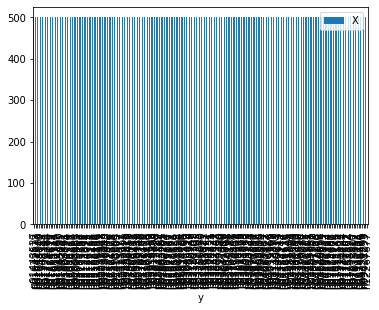

In [6]:
# Plot a histogram of our sample to class distribution
input_df.groupby('y').count().plot(kind='bar')

In [7]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
# Calculate bounds for throwing data away
PCT_CAT_TO_IMBALANCE = 0.01
LOWER_BOUND_IMBALANCE = 0.30
UPPER_BOUND_IMBALANCE = 0.60

unique_labels = list(set(y_train))
num_cats_to_imbalance = int(len(unique_labels) * PCT_CAT_TO_IMBALANCE)
np.random.shuffle(unique_labels)

imbalance_categories = ['n01882714', 'n04562935']
# NOTE: For reproducibility, hardcoding the results. For further experiments, uncomment this line
# imbalance_categories = unique_labels[:num_cats_to_imbalance]

print("Imbalancing categories: {}".format(imbalance_categories))

Imbalancing categories: ['n01882714', 'n04562935']


In [11]:
# Throw away random samples
X_train_imbal = []
y_train_imbal = []
for cat in imbalance_categories:
    imbalance_pct = np.random.uniform(LOWER_BOUND_IMBALANCE, UPPER_BOUND_IMBALANCE)

    print("Imbalancing {} with percent: {}".format(cat, imbalance_pct))
    
    indices = [x for x in range(len(y_train)) if y_train[x] == cat]
    np.random.shuffle(indices)
    num_to_discard = int(len(indices) * imbalance_pct)
    indices = indices[:num_to_discard]
    
    print("Kept {} samples for category {}".format(len(indices), cat))

    X_train_imbal.extend([X_train[x] for x in indices])
    y_train_imbal.extend([y_train[x] for x in indices])
    

Imbalancing n01882714 with percent: 0.4647883334345964
Kept 164 samples for category n01882714
Imbalancing n04562935 with percent: 0.4695671943782228
Kept 170 samples for category n04562935


In [12]:
imbalanced_df = pd.DataFrame({'X': X_train_imbal, 'y': y_train_imbal})
imbalanced_df

,X,y
0,tiny-imagenet-200/train/n01882714/images/n0188...,n01882714
1,tiny-imagenet-200/train/n01882714/images/n0188...,n01882714
2,tiny-imagenet-200/train/n01882714/images/n0188...,n01882714
3,tiny-imagenet-200/train/n01882714/images/n0188...,n01882714
4,tiny-imagenet-200/train/n01882714/images/n0188...,n01882714
...,...,...
329,tiny-imagenet-200/train/n04562935/images/n0456...,n04562935
330,tiny-imagenet-200/train/n04562935/images/n0456...,n04562935
331,tiny-imagenet-200/train/n04562935/images/n0456...,n04562935
332,tiny-imagenet-200/train/n04562935/images/n0456...,n04562935


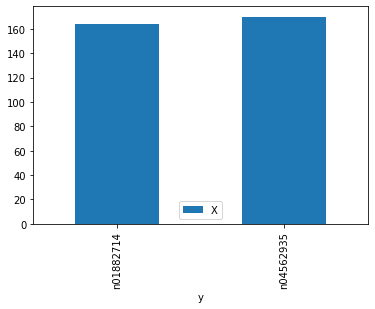

In [13]:
imbalanced_df.groupby('y').count().plot(kind='bar')

In [19]:
# Combine data into a single set
# NOTE: We do not do this for the holdout (i.e. test) set. Only our training set is imbalanced.
X_train_updated = [X_train[i] for i in range(len(y_train)) if y_train[i] not in imbalance_categories]
X_train_updated.extend(X_train_imbal)
y_train_updated = [y_train[i] for i in range(len(y_train)) if y_train[i] not in imbalance_categories]
y_train_updated.extend(y_train_imbal)
print(len(X_train_updated))
print(len(y_train_updated))

69617
69617


In [20]:
# Output expected test and train file:
def write_metadata(filename, X, y):
    assert(len(X) == len(y))
    with open(filename, 'w') as f:
        for i in range(len(X)):
            f.write('{}\t{}\n'.format(X[i], y[i]))

In [21]:
write_metadata('./metadata_output/test_metadata.txt', X_test, y_test)

In [24]:
write_metadata('./metadata_output/train_metadata.txt', X_train_updated, y_train_updated)

In [25]:
# Quick sanity check to make sure things weren't oddly manipulated (i.e. incorrect manipulation of label to data)
# We know the label is in the path.
for i in range(len(X_train)):
    assert(str(y_train[i]) in str(X_train[i]))
for i in range(len(X_test)):
    assert(str(y_test[i]) in str(X_test[i]))